In [1]:
import os, glob
import xarray as xr
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1 import ImageGrid
import json
import pickle
import csv

# Collect trial info

In [2]:
# Make sure to update the followings to the correct value
units_input = 124
units_output_upper = 128
units_output_lower = 128 # linear + relu

In [3]:
dir_results = '../results'
flist       = glob.glob(f'{dir_results}/*/*/*.csv')
RESULTS={}
for k, kf in enumerate(flist): # kf = f_csv
    RESULTS[k] = {}
    RESULTS[k]['lot'] = kf.split('/')[-3]
    RESULTS[k]['trial'] = kf.split('/')[-2]
    
    # collect csv data
    # : val loss
    work = pd.read_csv(kf)['val_loss']
    if len(work)!=12:  # -4 is for non-unit hp
        # cheange for unit_11 exist...
        del RESULTS[k] 
        continue
    RESULTS[k]['val_loss'] = np.array(work)
    RESULTS[k]['min_val_loss'] = work.min()
    RESULTS[k]['min_val_loss_epoch'] = work.argmin()+1 # 0-based index
        
    # collect json data
    # : num_layers activation  batch_size optimizer units_{klayer}
    f_json  = f"../results/{RESULTS[k]['lot']}/{RESULTS[k]['trial']}/trial.json"
    with open(f_json) as f:
        work = json.load(f)
    for khp in ['activation','batch_size','num_layers','optimizer']:
        RESULTS[k][khp] = work['hyperparameters']['values'][khp]

    # check the sanity of trial.json (for unit)
    
    # if False: #len(work['hyperparameters']['values'])-4 != 12:
    if f"units_{RESULTS[k]['num_layers']-1}" not in work['hyperparameters']['values'].keys():
        # print('ERROR (%s, %s)'%(RESULTS[k]['lot'], RESULTS[k]['trial']))
        del RESULTS[k]
        continue
    else:
        units = np.array( [work['hyperparameters']['values']['units_%d'%(k)] 
                           for k in range(RESULTS[k]['num_layers'])] )
        RESULTS[k]['units'] = units
    

    # Add Num_Params
    layers = np.array([units_input, *units, units_output_upper, units_output_lower])
    RESULTS[k]['num_parameters'] = np.sum((layers[:-1]+1) * layers[1:])
    
RESULTS_PD = pd.DataFrame(RESULTS).transpose()

In [4]:
# save RESULTS_PD to csv after sorting by val_loss
RESULTS_PD = pd.DataFrame(RESULTS).transpose()
RESULTS_PD.sort_values('min_val_loss', inplace=True)
print(len(RESULTS_PD))
RESULTS_PD.to_csv('step1_results.csv')

4358


# Visualization (HP vs. min val loss)

top 10% (blue) and top 1% (orange) models

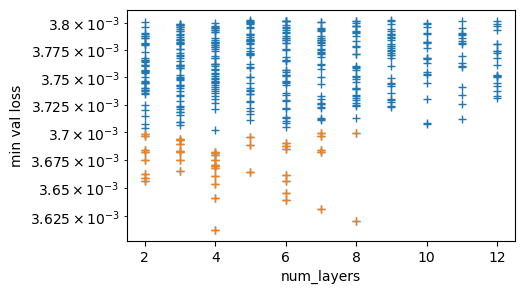

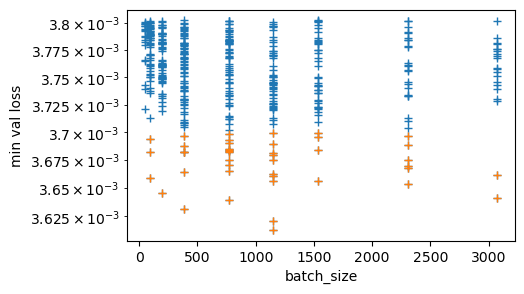

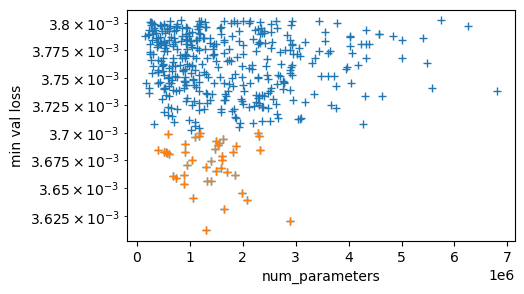

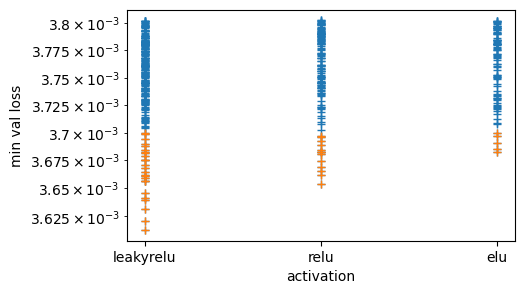

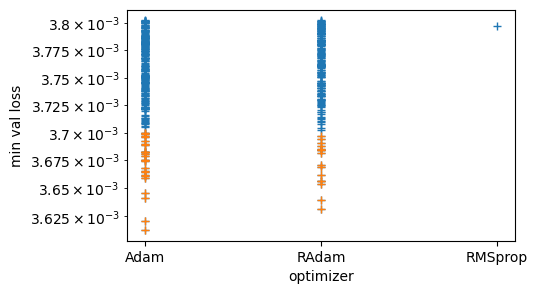

In [5]:
th_loss_10p = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.1))].iloc[-1] # top 10%
th_loss_1p  = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.01))].iloc[-1] # top 10%


for kvar in ['num_layers', 'batch_size', 'num_parameters', 'activation', 'optimizer']:
    fig, ax = plt.subplots()
    for kth in [th_loss_10p, th_loss_1p]:
        ploty = RESULTS_PD['min_val_loss']
        indy = ploty<kth
        ploty = ploty[indy]
        plotx = RESULTS_PD[kvar]
        plotx = plotx[indy]
        ax.plot(plotx,ploty, ls='none', marker='+')
    ax.set_yscale('log')
    ax.set_xlabel(kvar)
    ax.set_ylabel('min val loss')
    fig.set_size_inches(5,3)

top 99% (blue) and top 1% (orange) models

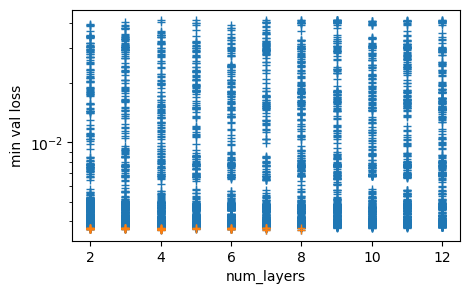

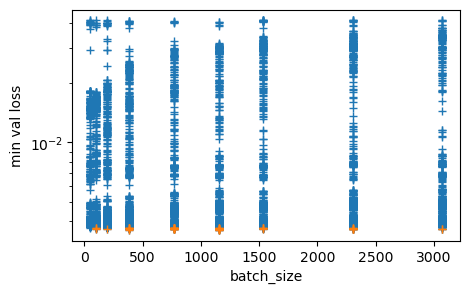

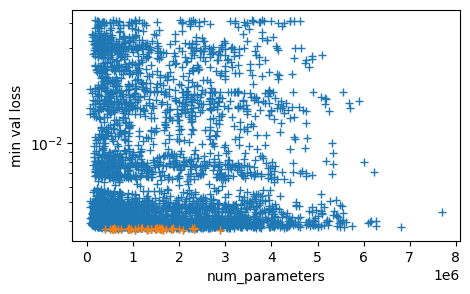

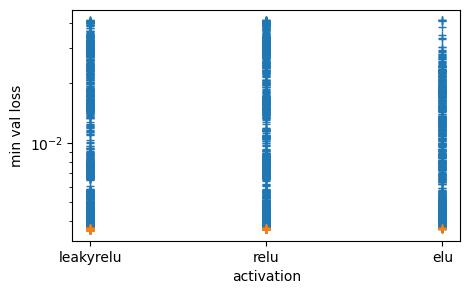

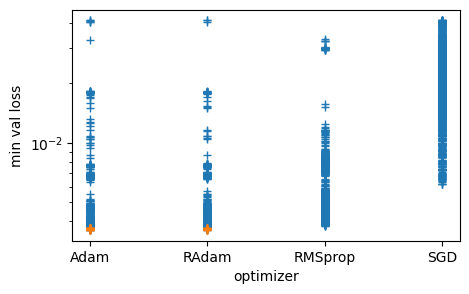

In [6]:
th_loss_99p = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*.99))].iloc[-1] # top 10% 
th_loss_10p = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.1))].iloc[-1] # top 10%
th_loss_1p  = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.01))].iloc[-1] # top 10%


for kvar in ['num_layers', 'batch_size', 'num_parameters', 'activation', 'optimizer']:
    fig, ax = plt.subplots()
    for kth in [th_loss_99p, th_loss_1p]:
        ploty = RESULTS_PD['min_val_loss']
        indy = ploty<kth
        ploty = ploty[indy]
        plotx = RESULTS_PD[kvar]
        plotx = plotx[indy]
        ax.plot(plotx,ploty, ls='none', marker='+')
    ax.set_yscale('log')
    ax.set_xlabel(kvar)
    ax.set_ylabel('min val loss')
    fig.set_size_inches(5,3)

num_params vs. num_layers

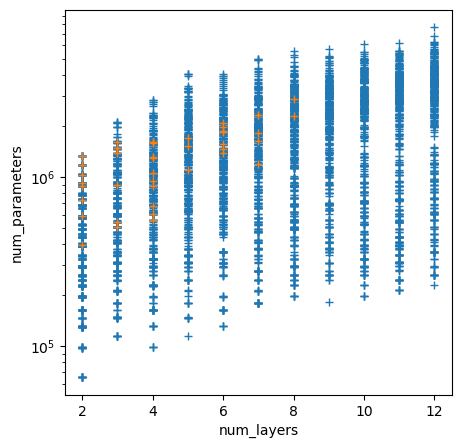

In [7]:
th_loss_99p = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*.99))].iloc[-1] # top 10% 
th_loss_10p = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.1))].iloc[-1] # top 10%
th_loss_1p  = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.01))].iloc[-1] # top 10%

kvar_y='num_parameters'
kvar_x='num_layers'
fig, ax = plt.subplots()
for kth in [th_loss_99p, th_loss_1p]:
    ploty = RESULTS_PD['min_val_loss']
    indy = ploty<kth
    ploty = RESULTS_PD[kvar_y]
    ploty = ploty[indy]
    plotx = RESULTS_PD[kvar_x]
    plotx = plotx[indy]
    ax.plot(plotx,ploty, ls='none', marker='+')
ax.set_yscale('log')
ax.set_xlabel(kvar_x)
ax.set_ylabel(kvar_y)
fig.set_size_inches(5,5)

# Pick the best models

In [8]:
RESULTS_PD = pd.DataFrame(RESULTS).transpose()
RESULTS_PD.sort_values('min_val_loss', inplace=True)
print(len(RESULTS_PD))

4358


In [9]:
TOP44 = RESULTS_PD.iloc[:44]
# TOP44['trial'].to_csv('top44.trial.v2.txt', sep='\n') # then, grep 'trial_'
# TOP44['lot'].to_csv('top44.lot.v2.txt', sep='\n')     # then, grep 'lot-'
TOP44

,lot,trial,val_loss,min_val_loss,min_val_loss_epoch,activation,batch_size,num_layers,optimizer,units,num_parameters
3370,lot-42,trial_0023,"[0.0043305773288011, 0.004145867191255, 0.0041...",0.003613,12,leakyrelu,1152,4,Adam,"[896, 256, 640, 1024]",1310208
2397,lot-38,trial_0046,"[0.0044661439023911, 0.0038614368531852, 0.004...",0.003621,12,leakyrelu,1152,8,Adam,"[896, 896, 1024, 256, 128, 128, 1024, 512]",2885120
2321,lot-38,trial_0091,"[0.0053012338466942, 0.0051548676565289, 0.004...",0.003632,12,leakyrelu,384,7,RAdam,"[128, 1024, 768, 128, 896, 384, 256]",1641728
3001,lot-50,trial_0070,"[0.0044522108510136, 0.0039233579300343, 0.004...",0.003639,12,leakyrelu,768,6,RAdam,"[768, 1024, 256, 1024, 384, 512]",2081920
2416,lot-38,trial_0083,"[0.0045032976195216, 0.0042308811098337, 0.003...",0.003641,12,leakyrelu,3072,4,Adam,"[640, 896, 128, 1024]",1048960
3306,lot-37,trial_0035,"[0.0042612827382981, 0.0041711330413818, 0.004...",0.003646,8,leakyrelu,192,6,Adam,"[640, 640, 768, 512, 512, 512]",1983744
3987,lot-41,trial_0023,"[0.0048454306088387, 0.0044215838424861, 0.004...",0.003654,12,relu,2304,4,RAdam,"[384, 512, 640, 384]",885376
3376,lot-42,trial_0110,"[0.0044814739376306, 0.0041346154175698, 0.003...",0.003656,12,leakyrelu,1152,2,RAdam,"[1024, 1024]",1325312
4546,lot-33,trial_0142,"[0.009143897332251, 0.0079495720565319, 0.0040...",0.003656,11,leakyrelu,1536,6,RAdam,"[512, 512, 128, 512, 512, 1024]",1394048
3239,lot-37,trial_0135,"[0.0043588662520051, 0.0039096614345908, 0.004...",0.003659,12,leakyrelu,96,2,Adam,"[1024, 512]",734976
